Introduction to Unsupervised Learning
======

In earlier labs we learned how to use linear regression to study whether certain features are useful in predicting an observed outcome. Then we used ensemble methods to refine our predictions. 

In this notebook, we shift from prediction to pattern finding. 

What we'll be doing in this notebook:
-----

1. Give a general introduction to unsupervised learning.
1. Use k-means clustering as unsupervised learning technique.
1. Load and explore a dataset.
1. Find clusters with k-means algorithm.
1. Evaluate our results with the Elbow method.

Unsupervised Learning: Pattern finding in data 🔍
------

Unsupervised Learning is the process of identifying patterns in a dataset. Identifying patterns is often an early step in understanding data. Unsupervised learning methods are a set of techniques designed to <i>explore</i> and find "hidden structure" rather than predict outcomes. 
 
Unsupervised learning does not require labeled data, therefore works for broader range of data. In fact, most data in the world is unlabelled. However, since there are no labels / correct answers there is not always a clear feedback to validate that the results are correct.

Unsupervised Learning is also called Data Mining.

Unsupervised
------

2 Types of Unsupervised Learning
--------

1. Dimension Reduction

1. Clustering

What is Dimension Reduction?
------

Dimension reduction aims to find fewer number of features that be used to build a meaningful model. There are many reasons for reducing the number of features in a dataset, from avoiding overfitting to speeding up modeling fitting time.

One of the most common dimension reduction techniques is Principal Component Analysis (PCA).

What is Clustering?
-----
<br>
<center><img src="./images/clustering.png" width="700"/></center>

Clustering is what it sounds like: chunking your data into sub-groups (clusters) based on similar characteristics. Then these sub-groups are used for later analysis. Clustering is an intuitive to understand the various natural segments that make up the population of your data. Clustering typically makes it easier to visualizes your data.

Clustering is also called [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis), data segmentation, or data partitioning.

We are going to focus on clustering for the rest of this notebook.

Introduction to K-means Clustering
------

<center><img src="./images/k_means.png" width="700"/></center>

K-means one of the most common clustering techniques. The goal of k-means is find a group of datapoints that close to each other (a cluster) and are far away from other datapoints (the other clusters).

How do we do k-means clustering?
-----

Initially, datapoints are <i>randomly assigned</i> to a cluster. Then the center of each cluster is calculated.

Then we alternate between two steps:

1. Assignment step: Observations are assigned to a cluster where the center is closest to them.

2. Update step: New center points of clusters are determined

The process repeats until observations shuffle are long around to different clusters anymore and the center of each cluster no longer moves.

In other words, observations are constantly being reassigned to clusters until the distance between an observation and their closest center point is minimized.

K-means Example
-----

![](../images/left.gif)

-----
Fitting K-means to Kiva Data
------

Now we are going to fit k-means to <b>partition</b> or <b>segment</b> the Kiva data into clusters.

Let's import the relevant packages to start coding:

In [1]:
# First, we need to clear the variables from the namespace 
# to make sure our analysis starts from scratch each time.
# -fs are arguments to keep history and ignore the confirmation prompt.

In [2]:
reset -fs 

In [3]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# K-Means clustering algorithm
from sklearn.cluster import KMeans

# Plotting
import seaborn as sns

# Places the plots in the Jupyter Notebook
%matplotlib inline

# Keep everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

----
Load and explore the data
-----

In [4]:
# Where the data is on the computer
path = '../data/'

filename = 'clean_data' # Has more columns

# Load data into Pandas 🐼
df = pd.read_csv(path+filename+'.csv.zip',
                 low_memory=False)

# TODO: Remove these lines once this is added to feature engineering
# Normalize column names
df.columns = [c.lower().replace('.', '_').replace(' ', '_')
              for c in df.columns]

It is always good idea 💡 to take a peak at the raw data.

In [5]:
df.head(n=2)

,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description_languages,description_texts_en,description_texts_es,description_texts_fr,description_texts_ru,funded_amount,funded_date,id,image_id,lender_count,loan_amount,location_geo_level,location_geo_pairs,location_town,name,partner_id,planned_expiration_date,posted_date,sector,status,tags,terms_disbursal_amount,terms_disbursal_currency,terms_disbursal_date,terms_loan_amount,terms_local_payments,terms_loss_liability_currency_exchange,terms_loss_liability_currency_exchange_coverage_rate,terms_loss_liability_nonpayment,terms_repayment_interval,terms_repayment_term,terms_scheduled_payments,themes,translator_byline,translator_image,...,#married_na,#orphan_na,#parent_na,#post-disbursed_na,#refugee_na,#repair_renew_replace_na,#repeat_borrower_na,#schooling_na,#single_na,#single_parent_na,#supporting_family_na,#sustainable_ag_na,#team_guys_holding_fish_na,#technology_na,#tourism_na,#trees_na,#unique_na,#vegan_na,#widowed_na,#woman_owned_biz_na,user_favorite_na,volunteer_like_na,volunteer_pick_na,num_borrowers_na,num_tags_na,female_na,num_male_na,num_female_na,pct_female_na,widowed_na,married_na,kids_na,parent_na,children_int_1_na,children_int_2_na,age_int_na,children_int_na,top_partner_id_na,partner_dollar_amount_na,exploratory_partner_na
0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",6.792162,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,0,500,town,-0.583333 35.183333,litein,Evaline,386.0,2017-06-08 00:00:00,2017-05-09 00:00:00,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03 07:00:00,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",6.792162,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,0,500,town,0.566667 34.566667,Bungoma,Julias,386.0,2017-06-08 00:00:00,2017-05-09 00:00:00,Manufacturing,fundraising,[],50000.0,KES,2017-04-03 07:00:00,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [6]:
print(f"There are {df.shape[1]:,} columns in the dataframe.")
print(f"There are {df.shape[0]:,} rows in the dataframe.")

There are 218 columns in the dataframe.
There are 118,199 rows in the dataframe.


In [7]:
df.describe()

,basket_amount,currency_exchange_loss_amount,funded_amount,id,image_id,lender_count,loan_amount,partner_id,terms_disbursal_amount,terms_loan_amount,terms_loss_liability_currency_exchange_coverage_rate,terms_repayment_term,translator_image,video_id,video_thumbnailimageid,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_delinquency_rate,partner_image_id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_profitability,partner_total_amount_raised,posted_year,posted_month,days_to_fund,days_to_expire,#animals,#biz_durable_asset,#eco-friendly,#elderly,#fabrics,#female_education,#first_loan,#health_and_sanitation,#hidden_gem,#inspiring_story,...,#married,#orphan,#parent,#post-disbursed,#refugee,#repair_renew_replace,#repeat_borrower,#schooling,#single,#single_parent,#supporting_family,#sustainable_ag,#team_guys_holding_fish,#technology,#tourism,#trees,#unique,#vegan,#widowed,#woman_owned_biz,user_favorite,volunteer_like,volunteer_pick,num_borrowers,num_tags,female,num_male,num_female,pct_female,widowed,married,kids,parent,children_int_1,children_int_2,age_int,children_int,top_partner_id,partner_dollar_amount,exploratory_partner
count,118199.000000,118199.000000,118199.000000,1.181990e+05,1.181990e+05,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,1.181990e+05,118199.000000,1.181990e+05,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,1.181990e+05,118199.000000,118199.000000,118199.000000,118199.000000,1.181990e+05,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,...,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,118199.000000,1.181990e+05,118199.000000
mean,0.185775,6.792162,460.031811,7.095884e+05,1.540860e+06,14.222303,481.271838,164.943231,41104.558639,481.271838,0.122171,13.404386,1.165682e+06,1038.878788,4.639814e+05,1.929306,30.053112,0.212500,3.823391,4.346358,1.496747e+06,11.517720,18190.648254,31.057951,2.363798,7.315619e+06,2013.558516,6.424894,8.006190,31.277834,0.058613,0.044459,0.081963,0.046329,0.014696,0.000981,0.047234,0.007250,0.000948,0.002183,...,0.000059,0.000347,0.292515,0.011777,0.000085,0.003519,0.111981,0.096321,0.007809,0.012014,0.014958,0.063765,0.000102,0.062666,0.000127,0.006811,0.001988,0.091642,0.005770,0.188233,0.130365,0.016413,0.024349,1.929238,1.017107,0.665615,0.957284,1.293471,60.696551,0.021811,0.640200,0.856200,0.863070,3.771163,4.500468,29.560149,2.103233,155.365570,1.232336e+06,0.111084
std,0.191674,3.589651,394.928783,3.413792e+05,6.045076e+05,12.654955,417.259618,65.911965,35795.447209,417.259618,0.040858,7.785041,5.136348e+05,19.979569,6.098745e+03,3.028876,17.083295,0.262511,10.482077,5.366385,6.022962e+05,10.825050,9413.644577,10.158114,10.739396,3.284701e+06,2.344082,3.559694,12.076792,4.922155,0.234900,0.206113,0.274310,0.210197,0.120332,0.031312,0.212140,0.084841,0.030768,0.046669,...,0.007695,0.018621,0.454920,0.107880,0.009198,0.059221,0.315344,0.295032,0.088022,0.108947,0.121385,0.244335,0.010075,0.242361,0.011265,0.082245,0.044545,0.288521,0.075741,0.390900,0.336706,0.127058,0.154130,3.028883,1.638101,0.471777,1.785047,2.098011,43.318136,0.146066,0.479944,0.350888,0.343775,1.282036,0.841229,11.687340,2.497462,66.427276,6.745737e+05,0.314237
min,0.000000,0.010000,0.000000,2.510000e+02,4.090000e+02,

Now that we have our data set up, we can begin partitioning our data into clusters based only a few features. Let's think about how to choose these…

As a potential borrower or lender, what would be interesting to explore? 

In the previous notebooks, we explored a number of interesting ideas, including:

- How much a borrower should ask to borrow
- The time it takes to fund a loan
- What features can influence the loan amount
- If we partition borrowers into distinct groups based on how quickly they can fund a loan, will we be able to learn anything about these groups of borrowers?

The k-means algorithm uses continuous-valued numeric features (k-means  can also be modified to work with categorical and ordinal features).

-----

Let's pick a couple of interesting continuous numeric features for analysis:

How are Funded Amount and Days to Fund related?
----

In [8]:
# Keep only the relevant columns
relavant_colums = ['funded_amount', 
                   'days_to_fund']
df = df[relavant_colums] 

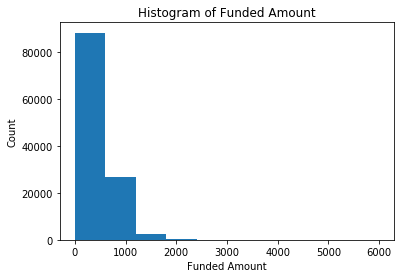

In [9]:
ax = df.funded_amount.hist(grid=False);

ax.set(xlabel='Funded Amount', 
       ylabel='Count', 
       title='Histogram of Funded Amount');  

_How can we interpret the number of loans at different funding amounts?_

<br>
<br>
<br>

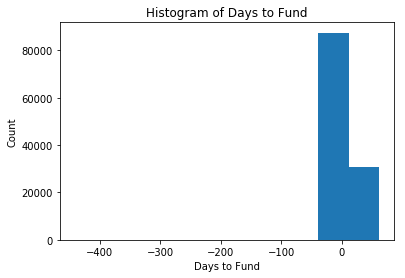

In [10]:
ax = df.days_to_fund.hist(grid=False);

ax.set(xlabel='Days to Fund', 
       ylabel='Count', 
       title='Histogram of Days to Fund');  

_How can we interpret the number of loans for different amount of times?_

<br>
<br>
<br>

In [11]:
# Filter data to remove outliers
funded_small = df.funded_amount < 2_500 # Remove large loans
time_valid = df.days_to_fund > 0 # Remove invalid times
df = df[funded_small & time_valid]

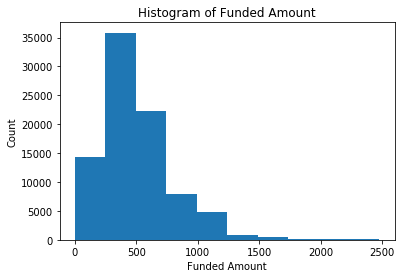

In [12]:
ax = df.funded_amount.hist(grid=False);

ax.set(xlabel='Funded Amount', 
       ylabel='Count', 
       title='Histogram of Funded Amount');  

,funded_amount,days_to_fund
0,0,8.00619
1,0,8.00619
2,0,8.00619
3,0,8.00619
4,0,8.00619


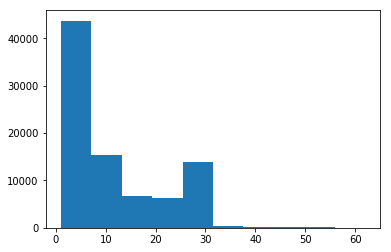

In [13]:
df.days_to_fund.hist(grid=False);df.head()

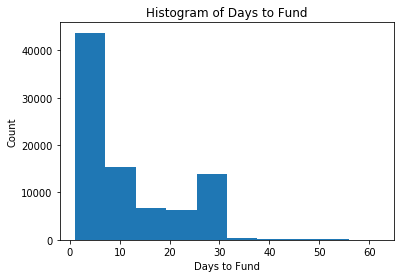

In [14]:
ax = df.days_to_fund.hist(grid=False);

ax.set(xlabel='Days to Fund', 
       ylabel='Count', 
       title='Histogram of Days to Fund');  

In [15]:
print(f"There are {df.shape[1]:,} columns in the dataframe.")
print(f"There are {df.shape[0]:,} rows in the dataframe.")

There are 2 columns in the dataframe.
There are 86,966 rows in the dataframe.


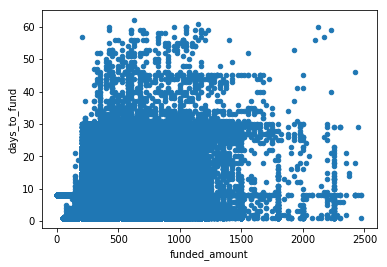

In [16]:
# Plot the relationship between these two variables
df.plot.scatter(x='funded_amount',
                y='days_to_fund');

_How can we interpret the relationship between the funded amount and time to fund?_

<br>
<br>
<br>

Clustering
======

----
Fitting our data with k-means using scikit-learn
----

Now we're ready to run the k-means algorithm:

Let's take quick peek at the [scikit-learn's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [17]:
# Take KMeans class, initialize and fit it our data
kmeans = KMeans(n_clusters=2) # Number of clusters should be 2 or 3
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now that we have clusters, the best way to understand them is to visualize them

In [18]:
# Add the cluster labels for each data point to the dataframe
df['kmeans_labels'] = kmeans.labels_

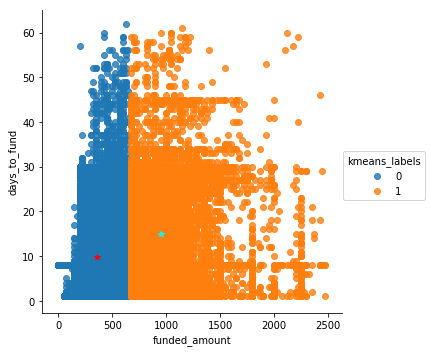

In [19]:
# Plot k-means
kmeans_plot = sns.lmplot(x="funded_amount", 
                       y="days_to_fund", 
                       data=df, 
                       fit_reg=False,        # Do not fit a regression line to the data
                       hue="kmeans_labels",  #'hue' will color code each group
                       legend=True);

# Plot the mean of cluster #1
kmeans_plot.ax.plot(kmeans.cluster_centers_[0][0], kmeans.cluster_centers_[0][1], color='red', marker='*');

# Plot the mean of cluster #2
kmeans_plot.ax.plot(kmeans.cluster_centers_[1][0], kmeans.cluster_centers_[1][1], color='cyan', marker='*');

# # Plot the mean of cluster #3 (if present)
# kmeans_plot.ax.plot(kmeans.cluster_centers_[2][0], kmeans.cluster_centers_[2][1], color='orange', marker='*');

_Why are the means where they are?_  

<br>
<br>
<br>

Choosing the number of clusters
-----

The k-means algorithm is somewhat naive -- it clusters the data into k clusters, even if k is not the right number of clusters to use.

We arbitrarily set the number of clusters to be 3. But determining the appropriate number of clusters (k) is actually one of the most challenging parts of clustering. 

There is no hard and fast rule for what the value of k should be because the number of clusters will depend on your data and what the goal of your analysis. The number of groups you choose to partition in your data directly influences the results you'll find. In most areas of data analysis, it's attractive to take as granular an approach as possible, but having too many clusters can be counterproductive because the grouping will not tell you much.

_Is it possible to have too many clusters? Or too few clusters?_

Think about these extreme examples: 

1. A single cluster for all your data 
2. A cluster for each data point

Neither of these will tell you anything new about your data! 

Rather, clustering is most effective when observations in the same cluster are very similar to each other. Also, we want observations in different clusters to be as different from each other as possible.

Elbow method to explore number of clusters
------

The elbow method is a simple, intuitive way of exploring how changing the number of clusters impacts the "tightness" of the clusters. 

The elbow method runs k-means clustering on the same dataset for a range of values of k (say, k is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) and for each value of k, calculate the within-cluster sum-of-squares errors (SSE).

SSE is the distance as-the-crow* flies between each point and closest mean, squared, and summed.

SSE is a measure of internally coherent clusters are. A lower is SSE is better (an inverted score), it means the each cluster is very similar to itself. SSE is like a golf score or heart-rate, lower is better.

As k increases, the improvement in SSE () will lesson. At some point this lack of improvement will be rapid, creating the "elbow" shape.

One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.

<sub>*The figure does not look like as-the-crow distance because each axis is on very different scales. Typically, k means data is normalized so data is on the same standard scale.</sub>

![](../images/elbow_method.png)

What the elbow method does is this:

1. Run the k-means algorithm over your dataset for a range of k.
2. For each value of k, calculate how the model fits.
3. If we see an "elbow" in our plotted check, then that marks a good value for k.

In [20]:
# Let's fit a different model for each value of k
k_values = range(1, 10)
k_mean_models = [KMeans(n_clusters=i) for i in k_values] # Fit a model for each value of k
scores = [-k_mean_models[i].fit(df).score(df) for i, model in enumerate(k_mean_models)] # See how the scores change

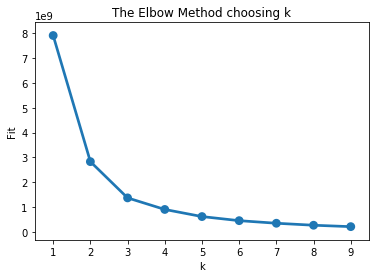

In [21]:
# Let's plot the effect k on the clustering
ax = sns.pointplot(x=list(k_values),
                   y=scores);
ax.set(xlabel='k', 
       ylabel='Fit', 
       title='The Elbow Method choosing k');

_How can we interpret the relationship between changing k and the fit of clustering?_  
_Can we see where the "bend" is that looks like an elbow in an arm?_

<br>
<br>
<br>

Summary
------

- We talked about how supervised learning finds patterns in data.
- Clustering is finding groups within a dataset.
- K-means clustering is a popular clustering technique that iteratively finds the best groups and center/means of groups.
- We fit k-means to data and evaluated the results.

Next Steps
-----

Apply the K-means clustering algorithm to a new pair of features. 

Then find an useful number of clusters (k).

Further study
-----

If you want to understand k-means at a deeper level, start at the notebook found [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

If you are interested in a more theory behind k-means, a great resource is [here](https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf). 

There are many other clustering methods. Another popular method is [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering).

<br>
<br> 
<br>

----